<a href="https://colab.research.google.com/github/abrahammathews2000/search4cyberplanet/blob/main/ML_model/ML_model_gcolab_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import require libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Upload lightcurve (input - x) and bezier shape (output - y)
# For 600 shapes

# Size of input (lightcurve) = 500 points
# Size of outpute (bezier curve) = 32 x 32 pixels

x_dir  = '/content/drive/MyDrive/msAstroDataProject/lc_dict.npy'
x = np.load(x_dir)

y_dir  = '/content/drive/MyDrive/msAstroDataProject/shape_dict.npy'
y = np.load(y_dir)
y = y/255.0

In [3]:
# Adding noise to the light curve

np.random.seed(100100)
stds = np.array([0.005,0.001,0.0005])
X_Noise = []
for el in x:
    i = np.random.randint(0,len(stds),1)
    noisearr = np.random.normal(1, stds[i], len(el))
    X_Noise.append(np.multiply(el, noisearr))

X_Noise = np.array(X_Noise)

In [4]:
# Splitting dataset into Train and Test (80 - 20)

xTrain, xTest, yTrain, yTest = train_test_split(X_Noise, y, test_size=0.20, random_state=1)
print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

(480, 500) (120, 500) (480, 32, 32) (120, 32, 32)


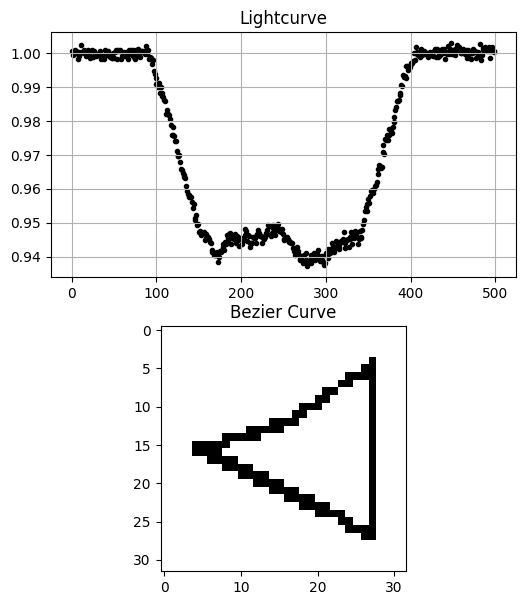

In [5]:
# Plotting lightcurve (noise added) and corresponding bezier shape
# from the training dataset

plt.figure(figsize = (6,7))
plt.style.use('default')
plt.rcParams.update({'font.size': 10})

plt.figure(1)
plt.subplot(211)
plt.scatter(np.arange(len(xTrain[5])),xTrain[5],marker = '.',label = "Lightcurve",color="black")
plt.title("Lightcurve")
plt.grid()

plt.subplot(212)
plt.title("Bezier Curve")
plt.imshow(yTrain[5],label = "Bezier shape",cmap='gray')
# plt.grid()
plt.show()

In [6]:
# Deep learning model (same as that used by Ushasi)


START = 500
END = 32
conv_ip = keras.layers.Input(shape=(START,),name='Input')
x=keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='relu',name='conv16_5', padding='same')(x)
x=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
x=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400
x=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
x=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
x=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200
x=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
x=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
x=keras.layers.MaxPool1D(3,strides=1,data_format='channels_last',name='maxpool_3', padding='same')(x) #100
x=keras.layers.Flatten(name='flat_1')(x)

x3=keras.layers.Dense(256,name='dense_layer_1',activation='relu')(x)
x3=keras.layers.Dense(256,name='dense_layer_2',activation='relu')(x3)

x3=keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x3)
x3 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x3)

x3=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x3)
x3=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x3)
x3=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x3)
x3=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x3)
conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x3)
model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
model.summary()


Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 500)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 500, 1)            0         
                                                                 
 batch_normalization (BatchN  (None, 500, 1)           4         
 ormalization)                                                   
                                                                 
 conv16_5 (Conv1D)           (None, 500, 16)           64        
                                                                 
 second_conv16_5 (Conv1D)    (None, 500, 16)           784       
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 250, 16)           0         
                                             

In [7]:
# Compiling model

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

# Train the model

model.fit(xTrain, yTrain, epochs=200,verbose=1, validation_split=0.2)

Epoch 1/200
12/12 [==============================] - 17s 38ms/step - loss: 0.8897 - val_loss: 0.8885
Epoch 2/200
12/12 [==============================] - 0s 12ms/step - loss: 0.8893 - val_loss: 0.8878
Epoch 3/200
12/12 [==============================] - 0s 15ms/step - loss: 0.8887 - val_loss: 0.8873
Epoch 4/200
12/12 [==============================] - 0s 15ms/step - loss: 0.8882 - val_loss: 0.8868
Epoch 5/200
12/12 [==============================] - 0s 15ms/step - loss: 0.8876 - val_loss: 0.8862
Epoch 6/200
12/12 [==============================] - 0s 14ms/step - loss: 0.8870 - val_loss: 0.8856
Epoch 7/200
12/12 [==============================] - 0s 14ms/step - loss: 0.8864 - val_loss: 0.8850
Epoch 8/200
12/12 [==============================] - 0s 14ms/step - loss: 0.8858 - val_loss: 0.8843
Epoch 9/200
12/12 [==============================] - 0s 15ms/step - loss: 0.8851 - val_loss: 0.8837
Epoch 10/200
12/12 [==============================] - 0s 15ms/step - loss: 0.8844 - val_loss: 0.882

In [8]:
# Evaluating model on Test dataset

model.evaluate(xTest, yTest)

4/4 [==============================] - 0s 81ms/step - loss: 0.0886


0.08857859671115875

4/4 [==============================] - 0s 4ms/step


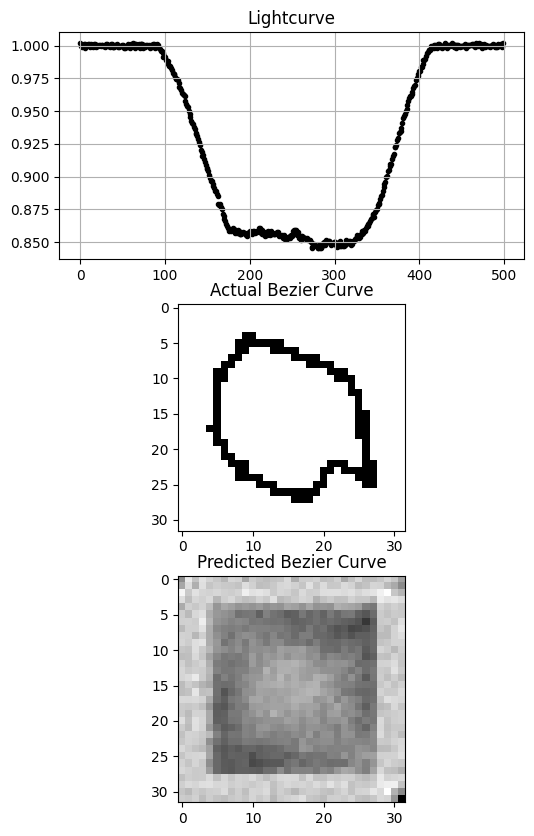

In [9]:
# Trying to predict shape for
# 1. Test data set
# 2. Train data set

# 1. Test data set
yPredictonTest = model.predict(xTest)


plt.figure(figsize = (6,10))
plt.style.use('default')
plt.rcParams.update({'font.size': 10})

plt.figure(1)
plt.subplot(311)
plt.scatter(np.arange(len(xTest[10])),xTest[10],marker = '.',label = "Lightcurve",color="black")
plt.title("Lightcurve")
plt.grid()

plt.subplot(312)
plt.title("Actual Bezier Curve")
plt.imshow(yTest[10],cmap='gray')

plt.subplot(313)
plt.title("Predicted Bezier Curve")
plt.imshow(yPredictonTest[10],cmap='gray')

plt.show()

15/15 [==============================] - 0s 3ms/step


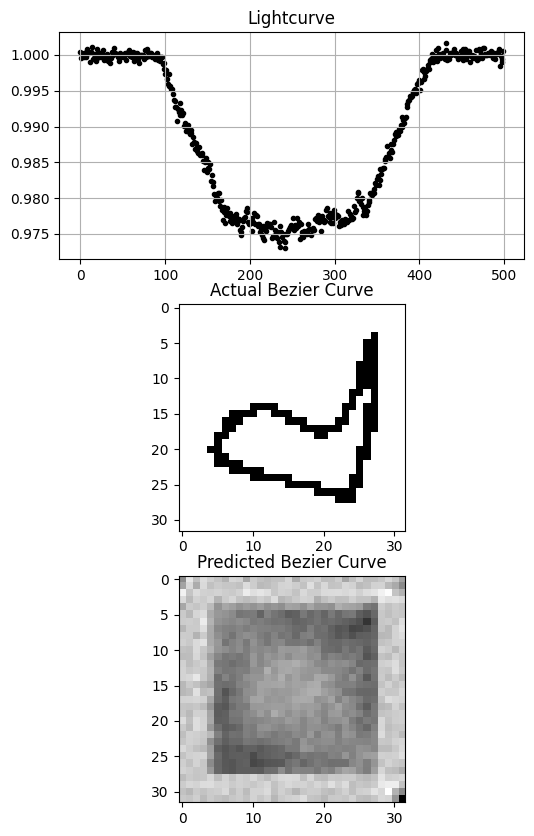

In [10]:
# 2. Train data set

yPredictonTrain = model.predict(xTrain)


plt.figure(figsize = (6,10))
plt.style.use('default')
plt.rcParams.update({'font.size': 10})

plt.figure(1)
plt.subplot(311)
plt.scatter(np.arange(len(xTrain[10])),xTrain[10],marker = '.',label = "Lightcurve",color="black")
plt.title("Lightcurve")
plt.grid()

plt.subplot(312)
plt.title("Actual Bezier Curve")
plt.imshow(yTrain[10],cmap='gray')

plt.subplot(313)
plt.title("Predicted Bezier Curve")
plt.imshow(yPredictonTrain[10],cmap='gray')

plt.show()

**Run below code to save the trained model**

In [11]:
from tensorflow.keras.models import save_model, load_model

In [12]:
save_model(model, "model.h5")

In [13]:
model_upload = load_model('model.h5')
# summarize model.
model_upload.summary()

Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 500)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 500, 1)            0         
                                                                 
 batch_normalization (BatchN  (None, 500, 1)           4         
 ormalization)                                                   
                                                                 
 conv16_5 (Conv1D)           (None, 500, 16)           64        
                                                                 
 second_conv16_5 (Conv1D)    (None, 500, 16)           784       
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 250, 16)           0         
                                             